<a href="https://colab.research.google.com/github/mttcrn/AI-things/blob/main/Machine%20Learning/06-My_Kernel_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel Methods
We will analyse the use of kernel methods to perform regression and classification tasks.
At first, we use Gaussian process to compute the value of the petal width given the petal length in the Iris dataset. After that, we use SVMs to classify the setosa and non-setosa flowers.

## Gaussian Process

In [14]:
import numpy as np
from scipy.stats import zscore
from sklearn import datasets

dataset = datasets.load_iris()

x = zscore(dataset.data[:, 2]).reshape(-1, 1) # column 2 of data is petal length
t = zscore(dataset.data[:, 3]) # column 3 of data is petal width

Once we have our dataset, we would like to set up a GP for regression

At first we set up our kernel. In this case we choose a standard Gaussian kernel, a.k.a. RBF (radial basis function) kernel:
$$K(\mathbf{x}, \mathbf{y}) : = \phi \exp \left\{ - \frac{||\mathbf{x} - \mathbf{y}||_2^2}{2 l^2} \right\}$$

Moreover, we have to choose the value of the variance $\sigma^2$ of the noise of the data we are considering.

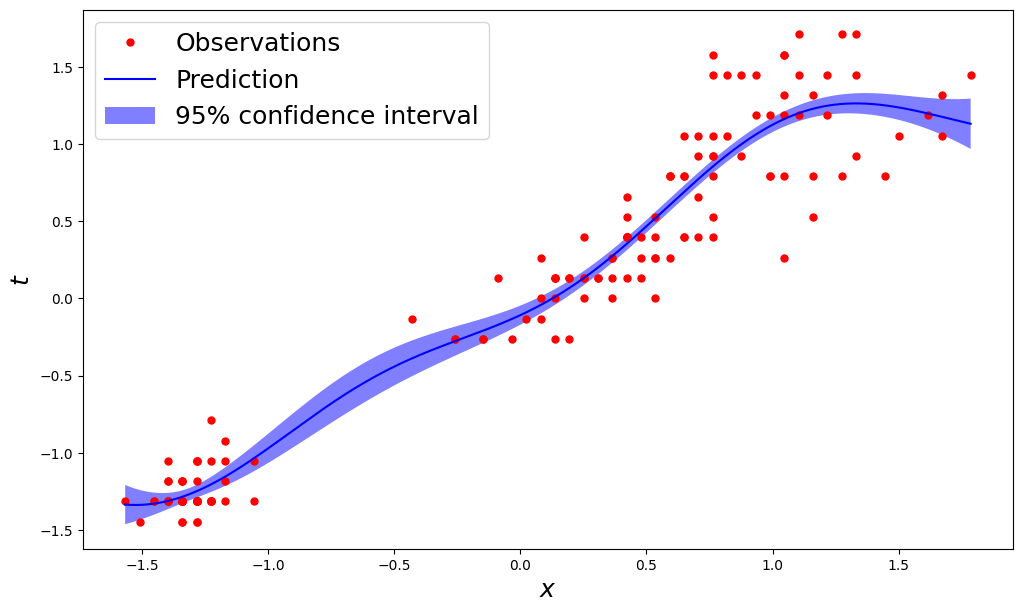

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

#Kernel values
phi = 0.7
l = 0.9
sigma_sq = 0.02
# RBF (radial basis function) stands for a Gaussian kernel
kernel = ConstantKernel(phi, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
# parameter alpha is the noise of the output (it may be known or guessed)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_sq).fit(x, t)
x_pred = np.linspace(np.min(x),np.max(x),5000).reshape(-1,1)
t_pred, sigma = gpr.predict(x_pred, return_std=True)
plt.figure(figsize=(12,7))
plt.plot(x, t, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, t_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([t_pred - 1.9600 * sigma,
                        (t_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$t$', fontsize=18)
plt.legend(loc='upper left', fontsize=18)

# it gives a (Gaussian) distribution of possible output values
# for each x it predicts the expectation and a confidence interval for the outputs

Changing the values of the kernel parameters influences the dynamic of the GP
For instance if:
- set $l = 8$ we increase the smoothness of the GP
- set $\sigma^2 = 10$ we increase the noise in each point
- set $\phi = 100$ we increase the influence of the kernel to the results


To optimize these parameters before starting the regression procedure, we can use either an independent dataset or cross-validation to estimate them, maximizing the likelihood of the considered samples. In what follows, we will use the points from the Iris dataset to optimize the parameter $l$ and $\phi$.

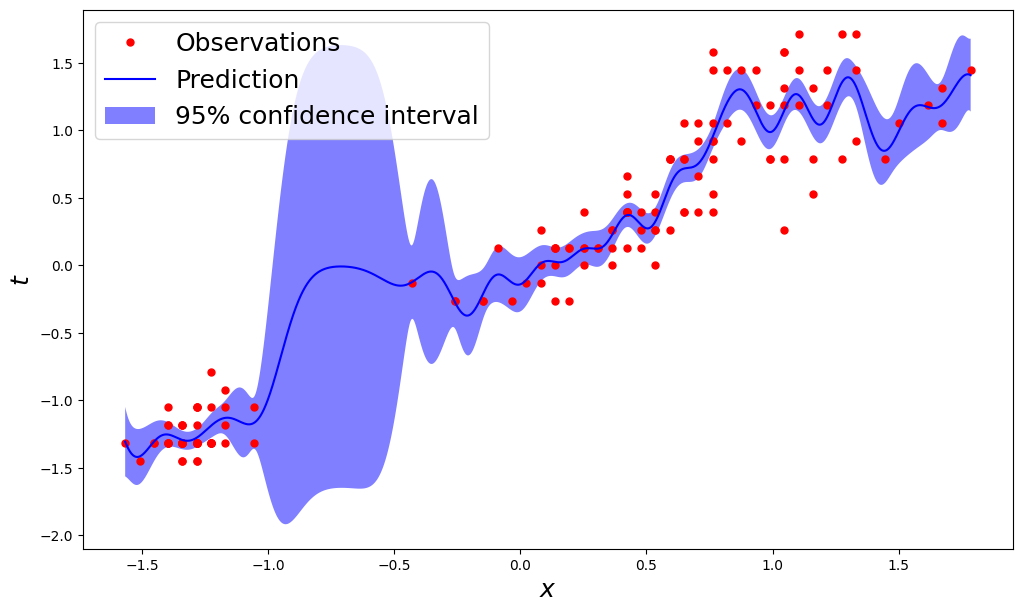

In [16]:
kernel = ConstantKernel(phi, constant_value_bounds="fixed") * RBF(0.1, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_sq).fit(x, t)
x_pred = np.linspace(np.min(x),np.max(x),5000).reshape(-1,1)
t_pred, sigma = gpr.predict(x_pred, return_std=True)
plt.figure(figsize=(12,7))
plt.plot(x, t, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, t_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([t_pred - 1.9600 * sigma,
                        (t_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$t$', fontsize=18)
plt.legend(loc='upper left', fontsize=18)


## some notes on trade-off between complexity and the ability to generalize on unseen data

# l is the lenght scale: it controls the smoothness of the function that the GPR learns
# a larger l make the function collaps into a line (smoother function)
# a smaller l make the function less smooth, with more changes and more complex
 # (a sort of overfitting as the model captures the noise)

# sigma^2 is the noise variance: it represents the uncertainty (noise) in the observed data
# a larger sigma^2 enlarge the width of the confidence interval
# a smaller sigma^2 make confidence interval tight to the prediction

In [17]:
gpr.kernel_

0.837**2 * RBF(length_scale=0.1)

Finally, a useful resource for GPs https://thegradient.pub/gaussian-process-not-quite-for-dummies/

## SVM
The application of kernel methods to classification is easily exemplified in the SVMs

We start with the linear formulation, for which we are applying a linear kernel $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^\top \mathbf{y}$



In [18]:
from sklearn import svm

input = zscore(dataset.data[:, [0, 1]]) # column 0,1 are sepal length and sepal width

# the dataset is stored in the variable iris
target = dataset.target.copy()
# 0 - setosa, 1 - versicolor, 2 - virginica
target[target == 1] = 2
target[target == 0] = 1
target[target == 2] = 0

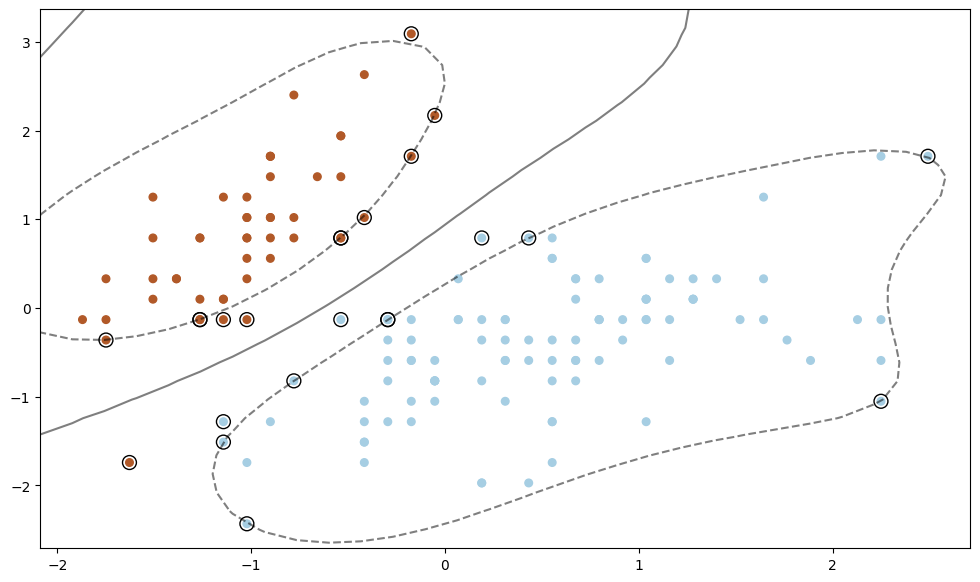

In [19]:
SVM_model = svm.SVC() # default kernel is 'rbf'
#default scale coefficient (gamma="scale", corresponding to 1/l) is a heuristic value
SVM_model.fit(input, target)

plt.figure(figsize=(12,7))

plt.scatter(input[:, 0], input[:, 1], c=target, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
#evaluate the SVM value for the positive class
Z = SVM_model.decision_function(xy).reshape(XX.shape)

# plot decision boundary (w^Tx =  0) and margins (w^Tx = 1 and w^Tx = -1)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(SVM_model.support_vectors_[:, 0], SVM_model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

The margins are not linear anymore. We still have the support vectors (How can we identify them?) which are those data that are used to provide a prediction.